# HDBSCAN* Clustering Tutorial

This guide will show how to use Tribuo’s HDBSCAN* clustering package to find clusters and outliers using a toy dataset. We'll also look at how to visualize the results and make predictions for new data points. The details of this implementation are described in [this Applied Sciences journal article.](https://doi.org/10.3390/app12052405)

## Setup

We'll load in some jars and import a few packages. The xchart jar is needed for the plots, and can be downloaded from [Maven Central](https://search.maven.org/artifact/org.knowm.xchart/xchart/3.8.1/jar)

In [1]:
%jars ./tribuo-clustering-hdbscan-4.3.0-jar-with-dependencies.jar
%jars ./xchart-3.8.1.jar

In [2]:
import org.tribuo.*;
import org.tribuo.clustering.*;
import org.tribuo.clustering.hdbscan.*;
import org.tribuo.data.columnar.*;
import org.tribuo.data.columnar.processors.field.DoubleFieldProcessor;
import org.tribuo.data.columnar.processors.response.EmptyResponseProcessor;
import org.tribuo.data.csv.CSVDataSource;
import org.tribuo.math.distance.DistanceType;
import org.tribuo.math.neighbour.NeighboursQueryFactoryType;
import org.knowm.xchart.*;
import org.knowm.xchart.style.markers.*;
import java.awt.Color;
import java.nio.file.Paths;
import java.util.*;

## Declare some methods to help with plotting
We'll declare a few methods that are useful for visualizing the results. If you're not really interested in how this is done, just skip down to the next heading.

In [3]:
// A method to get a new instance of a chart, configured the same way each time
XYChart getNewXYChart(String title) {
    XYChart chart = new XYChartBuilder().width(600).height(400).title(title).xAxisTitle("X").yAxisTitle("Y").build();
    chart.getStyler().setDefaultSeriesRenderStyle(XYSeries.XYSeriesRenderStyle.Scatter);
    chart.getStyler().setChartTitleVisible(false);
    chart.getStyler().setLegendVisible(false);
    chart.getStyler().setMarkerSize(8);
    chart.getStyler().setPlotGridHorizontalLinesVisible(false);
    chart.getStyler().setPlotGridVerticalLinesVisible(false);
    return chart;
}

In [4]:
// A method to add a set of (x,y) points to a chart
void addSeriesToChart(XYChart chart, List<Double> xList, List<Double> yList, String seriesName, Color color, Marker marker) {
    XYSeries xYseries = chart.addSeries(seriesName,
        xList.stream().mapToDouble(Double::doubleValue).toArray(),
        yList.stream().mapToDouble(Double::doubleValue).toArray());
    xYseries.setMarkerColor(color);
    xYseries.setMarker(marker);
}

In [5]:
// A method to multiple sets of (x,y) points to a chart
void addAllSeriesToChart(XYChart chart, Map<Integer, List<Double>> mapX, Map<Integer, List<Double>> mapY, Queue<Color> colors) {
    for (Map.Entry<Integer, List<Double>> entry : mapX.entrySet()) {
        if (entry.getKey() == 0) {    // The Outlier label
            List<Double> xList = entry.getValue();
            List<Double> yList = mapY.get(0);
            addSeriesToChart(chart, xList, yList, "Points" + entry.getKey(), Color.darkGray, SeriesMarkers.CIRCLE);
        } else {                      // Valid Cluster labels
            List<Double> xList = entry.getValue();
            List<Double> yList = mapY.get(entry.getKey());
            addSeriesToChart(chart, xList, yList, "Points" + entry.getKey(), colors.poll(), SeriesMarkers.CIRCLE);
        }
    }
}

In [6]:
// A method which extracts the (x,y) points from the dataset
void setXandYListsFromDataset(List<Double> xList, List<Double> yList, Dataset<ClusterID> dataset) {
    for (Example<ClusterID> ex : dataset) {
        int i = 0;
        for (Feature f : ex) {
            if (i == 0)  xList.add(f.getValue());
            if (i == 1)  yList.add(f.getValue());
            i++;
        }
    }
}

## Dataset
The toy dataset we'll be using is a small set of 2-dimensional points. A dataset like this with so few samples and only 2 features isn't very realistic, but makes it easy to see how to use Tribuo's HDBSCAN* clustering package.

First, we'll load the training data.

In [7]:
Map<String, FieldProcessor> regexMappingProcessors = new HashMap<>();
regexMappingProcessors.put("Feature1", new DoubleFieldProcessor("Feature1"));
regexMappingProcessors.put("Feature2", new DoubleFieldProcessor("Feature2"));
RowProcessor<ClusterID> rowProcessor = new RowProcessor<>(new EmptyResponseProcessor<>(new ClusteringFactory()), regexMappingProcessors);

var csvDataSource = new CSVDataSource<>(Paths.get("simple-2d-data/simple-2d-data-train.csv"), rowProcessor, false);
var dataset = new MutableDataset<>(csvDataSource);

Now, we can look at a plot of the points.

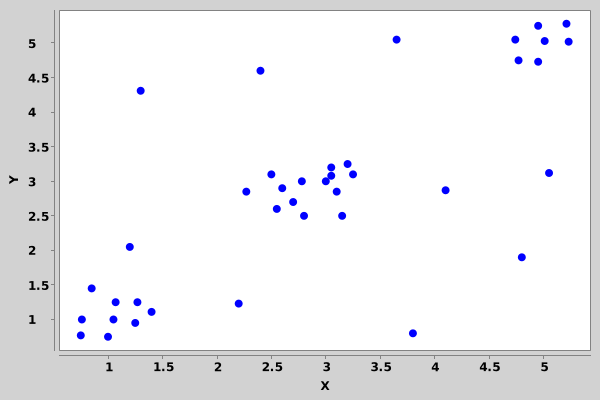

In [8]:
List<Double> xList = new ArrayList<>();
List<Double> yList = new ArrayList<>();
setXandYListsFromDataset(xList, yList, dataset);

var chart = getNewXYChart("Dataset");
addSeriesToChart(chart, xList, yList, "Points", Color.blue, SeriesMarkers.CIRCLE);
BitmapEncoder.getBufferedImage(chart);

## Model Training
We'll fit an HDBSCAN* model using a minimum cluster size of 5. This defines the minimum number of points required to form a cluster.

In [9]:
var trainer = new HdbscanTrainer(5);
var model = trainer.train(dataset);

Querying the model, we can see that 4 different cluster labels were identified. The cluster label 0 is the outlier label and indicates that some points in the dataset are marked as outliers or noise. That means the model found 3 distict clusters and some outlier points.

In [10]:
var clusterLabels = model.getClusterLabels();
var labelsSet = new HashSet<>(clusterLabels);
System.out.println(labelsSet);

[0, 3, 4, 5]


Using the cluster labels discovered by the model, we can organize the data to make it easy to visualize.

In [11]:
Map<Integer, List<Double>> mapX = new HashMap<>();
Map<Integer, List<Double>> mapY = new HashMap<>();
int i = 0;
for (Integer label : clusterLabels) {
    List<Double> lx = mapX.computeIfAbsent(label, p -> new ArrayList<>());
    lx.add(xList.get(i));
    List<Double> ly = mapY.computeIfAbsent(label, p -> new ArrayList<>());
    ly.add(yList.get(i));
    i++;
}

Now, let's see that visualization.

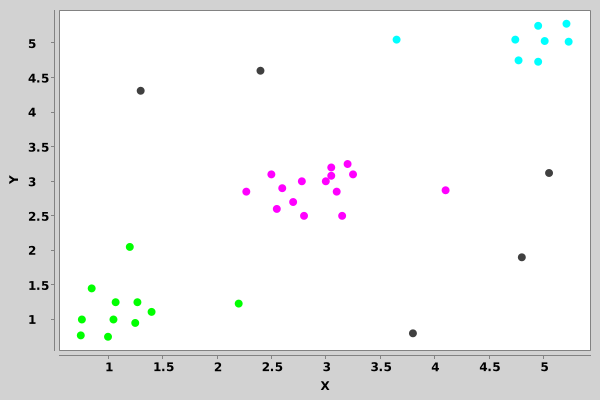

In [12]:
// Since there are 3 distict clusters, we add 3 different colors to a queue to be used in the chart.
Queue<Color> colors = new ArrayDeque<>();
colors.add(Color.cyan); colors.add(Color.green); colors.add(Color.magenta);

chart = getNewXYChart("Cluster Result");
addAllSeriesToChart(chart,  mapX,  mapY, colors);
BitmapEncoder.getBufferedImage(chart);

## Outlier Scores
An HDBSCAN* model calculates an outlier score for each point. These are values between 0 and 1, where points with higher outlier scores are more likely to be outliers. For example, we can query the model to see the outlier score for point (1.3, 4.31), which happens to be the point at index 9 in the dataset.

In [13]:
System.out.println(model.getOutlierScores().get(9));

0.8449704929196467


Looking at the point (1.05, 1.0) which is near the center of the green cluster, we expect a lower outlier score. For the interested reader, this point is at index 4 in the dataset.

In [14]:
System.out.println(model.getOutlierScores().get(4));

0.0


## Predictions
Tribuo's HDBSCAN* clustering package conforms to the standard `Trainer` and `Model` interfaces used for the rest of Tribuo, so predictions can be made for new data points.

Let's load a few new points.

In [15]:
CSVDataSource<ClusterID> csvPredictDataSource = new CSVDataSource<>(Paths.get("simple-2d-data/simple-2d-data-predict.csv"), rowProcessor, false);
Dataset<ClusterID> predictDataset = new MutableDataset<>(csvPredictDataSource);

The new points are: (4.25, 1.5) (3.9, 4.5) and (1.5, 3.0). We can add those to the existing plot of clusters using a red diamond marker to differentiate them.

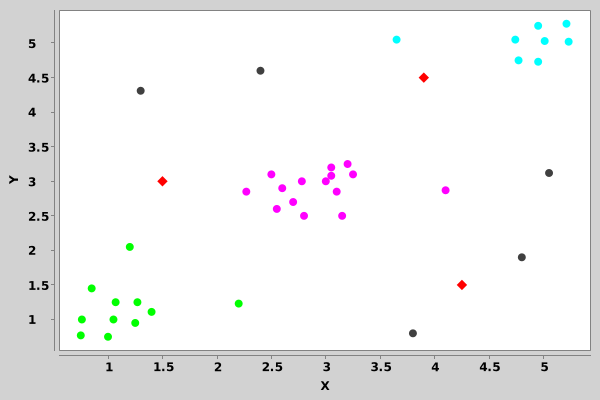

In [16]:
xList = new ArrayList<>();
yList = new ArrayList<>();
setXandYListsFromDataset(xList, yList, predictDataset);
addSeriesToChart(chart, xList, yList, "New Points", Color.red, SeriesMarkers.DIAMOND);
BitmapEncoder.getBufferedImage(chart);

Now, let's make the prediction call.

In [17]:
var predictions = model.predict(predictDataset);

Using the predicted cluster labels, we add the new points to the existing maps to prepare the updated data for visualization.

In [18]:
List<Integer> predictionLabels = new ArrayList<>();
predictions.forEach(p -> predictionLabels.add(p.getOutput().getID()));

i = 0;
for (Integer label : predictionLabels) {
    List<Double> lx = mapX.computeIfAbsent(label, p -> new ArrayList<>());
    lx.add(xList.get(i));
    List<Double> ly = mapY.computeIfAbsent(label, p -> new ArrayList<>());
    ly.add(yList.get(i));
    i++;
}

We could have just printed out the cluster labels for the new points, but a visualization is better.

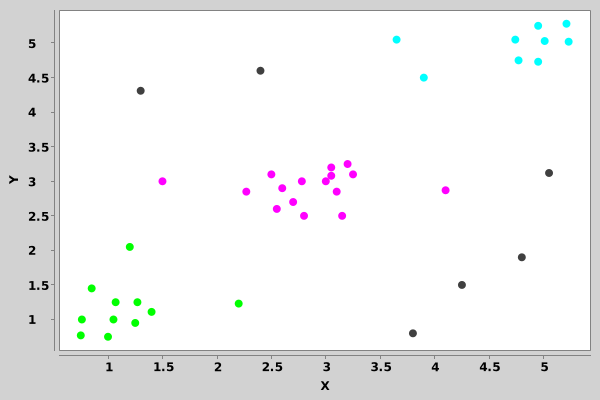

In [19]:
// Again, we want to set the correct colors to be used in the chart.
colors.add(Color.cyan); colors.add(Color.green); colors.add(Color.magenta);
chart = getNewXYChart("Prediction Result");
addAllSeriesToChart(chart,  mapX,  mapY, colors);
BitmapEncoder.getBufferedImage(chart);

The point (4.25, 1.5) is marked as an outlier. The point (1.5, 3.0) is shown to belong to the magenta colored cluster in the middle. Let's check the predicted outlier scores for these two points.

In [20]:
System.out.println("The outlier score for (4.25, 1.5) is : " + predictions.get(0).getOutput().getScore());
System.out.println("The outlier score for (1.5, 3.0) is : " + predictions.get(2).getOutput().getScore());

The outlier score for (4.25, 1.5) is : 0.8492520788446892
The outlier score for (1.5, 3.0) is : 0.02241334109160653


## Optimizing Training Performance
Tribuo's HDBSCAN* package supports multi-threading for the core distance calculations step of the algorithm. For larger datasets, it is certainly worthwhile to train the model with multiple threads. 

Additionally the core distance calculations, which are just nearest neighbour queries, can be done using different techniques. The default technique uses a brute-force algorithm, which calculates the distances between all points and tracks the `k` smallest distances. The other technique uses a k-d tree algorithm, which may reduce the time to make nearest neighbour queries for some datasets. Further, the k-d tree algorithm may use more memory when training a model compared with the brute-force algorithm. 

This is how to instantiate a trainer to use 4 threads, and the brute-force algorithm. To use the k-d tree algorithm instead, the fifth parameter would be `NeighboursQueryFactoryType.KD_TREE`.

In [21]:
var trainer = new HdbscanTrainer(5,    // The minimum cluster size
                                 DistanceType.L2.getDistance(),  // The distance function 
                                 5,    // The number of neighbors to use to calculate the core-distance
                                 4,    // The number of compute threads
                                 NeighboursQueryFactoryType.BRUTE_FORCE  // The nearest neighbour query algorithm
                                );

## Conclusion
We looked at Tribuo's HDBSCAN\* implementation and saw how to train a model, then make predictions with that model. HDBSCAN\* stands for heirarchical density-based spatial clustering of applications with noise and yes, the original authors of the algorithm have used an asterisk in the name.

We plan to further expand Tribuo's clustering functionality to incorporate other algorithms in the future. If you want to help, or have specific algorithmic requirements, file an issue on our [github page](https://github.com/oracle/tribuo).